# Chemical data analysis and visualization (part 2)

### Library imports

In [2]:
library(openxlsx)
library(tidyverse)
library(ggbreak)
# library(NADA) # - locaded by the source file tau_correlation-matrix.R 
library(factoextra)
library(latex2exp)
library(cowplot)
library(ggdendro)
library(ggcorrplot)

In [3]:
img.path <- "../publication/IMG/"

### 1. Importing the dataset
Detailed explanation in [chemical_data1.ipynb](chemical_data1.ipynb)

In [4]:
df.lod <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=2)
head(df.lod,2)

,Column.name,Full.name,Units,LOD,LOQ,Recommendation_low,Recommendation_top,comment
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,pH,pH,[-],0,0,6.5,8.5,0 means no LOD / LOQ
2,conductivity,conductivity,[uS/cm],0,0,NA,2000.0,0 means no LOD / LOQ


In [5]:
df <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=1)
df["sampling.date"] <- openxlsx::convertToDate(df[["sampling.date"]])
head(df,3)

,sample.name,sampling.date,sampling.site,country,region,district.place,water.source.type,water.source.type.flag,measurement.series,loc.x,⋯,SA,SA.LOQ,SNI,SNI.LOQ,meq.Cl,meq.SO4,meq.Na,meq.K,meq.Cl+SO4,meq.Na+K
,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MAD_1,2014-12-01,Lake in Tsinjofary,Madagascar,Tsinjofary,NA,lake,MAD1,MAD_A,47.64074,⋯,0.05,TRUE,0.1,TRUE,0.3497884,0.05075466,0.5891257,0.28780051,0.40054309,0.8769262
2,MAD_2,2014-12-01,Lake in Tsararivotra,Madagascar,Tsararivotra,NA,lake,MAD2,MAD_A,47.60931,⋯,0.05,TRUE,0.1,TRUE,0.1184767,0.03060269,0.6078730,0.29485934,0.14907941,0.9027323
3,MAD_3,2014-12-01,Lake in Andilambe,Madagascar,Andilambe,NA,lake,MAD3,MAD_A,47.47847,⋯,0.05,TRUE,0.1,TRUE,0.0448519,0.02058915,0.3886907,0.08611253,0.06544106,0.4748033


### 2. Principal component analysis of the data
Preparing the dataset for PCA

In [6]:
cn <- colnames(df)[12:length(colnames(df))]
pca.feat <-  cn[!str_detect(cn,".LOQ")] # excluding the columns with LOQ flags
pca.feat <- pca.feat[!str_detect(pca.feat,"meq.")] # exclude values expressed in meq
pca.feat <- pca.feat[-match("formaldehyde",pca.feat)] # exluding formaldehyde due to many missing values

df.pca <- df[pca.feat]
rownames(df.pca) <- df$sample.name
df.pca["water.source.type"] <- as.integer(factor(df$water.source.type))
head(df.pca,2)

,pH,conductivity,F,Cl,Br,NO3,NO2,SO4,PO4,Li,⋯,K,NH4,Ca2,Mg2,TOC,phenols,CS,SA,SNI,water.source.type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
MAD_1,7.72,103.5,0.827,12.4,0.18,1.60,0.27,2.438,0.270,0.03,⋯,11.253,9.401,0.030,0.030,8.165,0.254,0.05,0.05,0.1,2
MAD_2,7.12,155.3,0.203,4.2,0.18,0.18,0.27,1.470,0.818,0.03,⋯,11.529,9.815,1.016,1.409,8.459,0.044,0.05,0.05,0.1,2


In [7]:
pca.res <- prcomp(df.pca,scale=TRUE)

In [8]:
pca.theme <- theme(text = element_text(size = 16),
                   axis.title = element_text(size = 18),
                   axis.text = element_text(size = 18),
                   legend.text= element_text(size = 14)) 

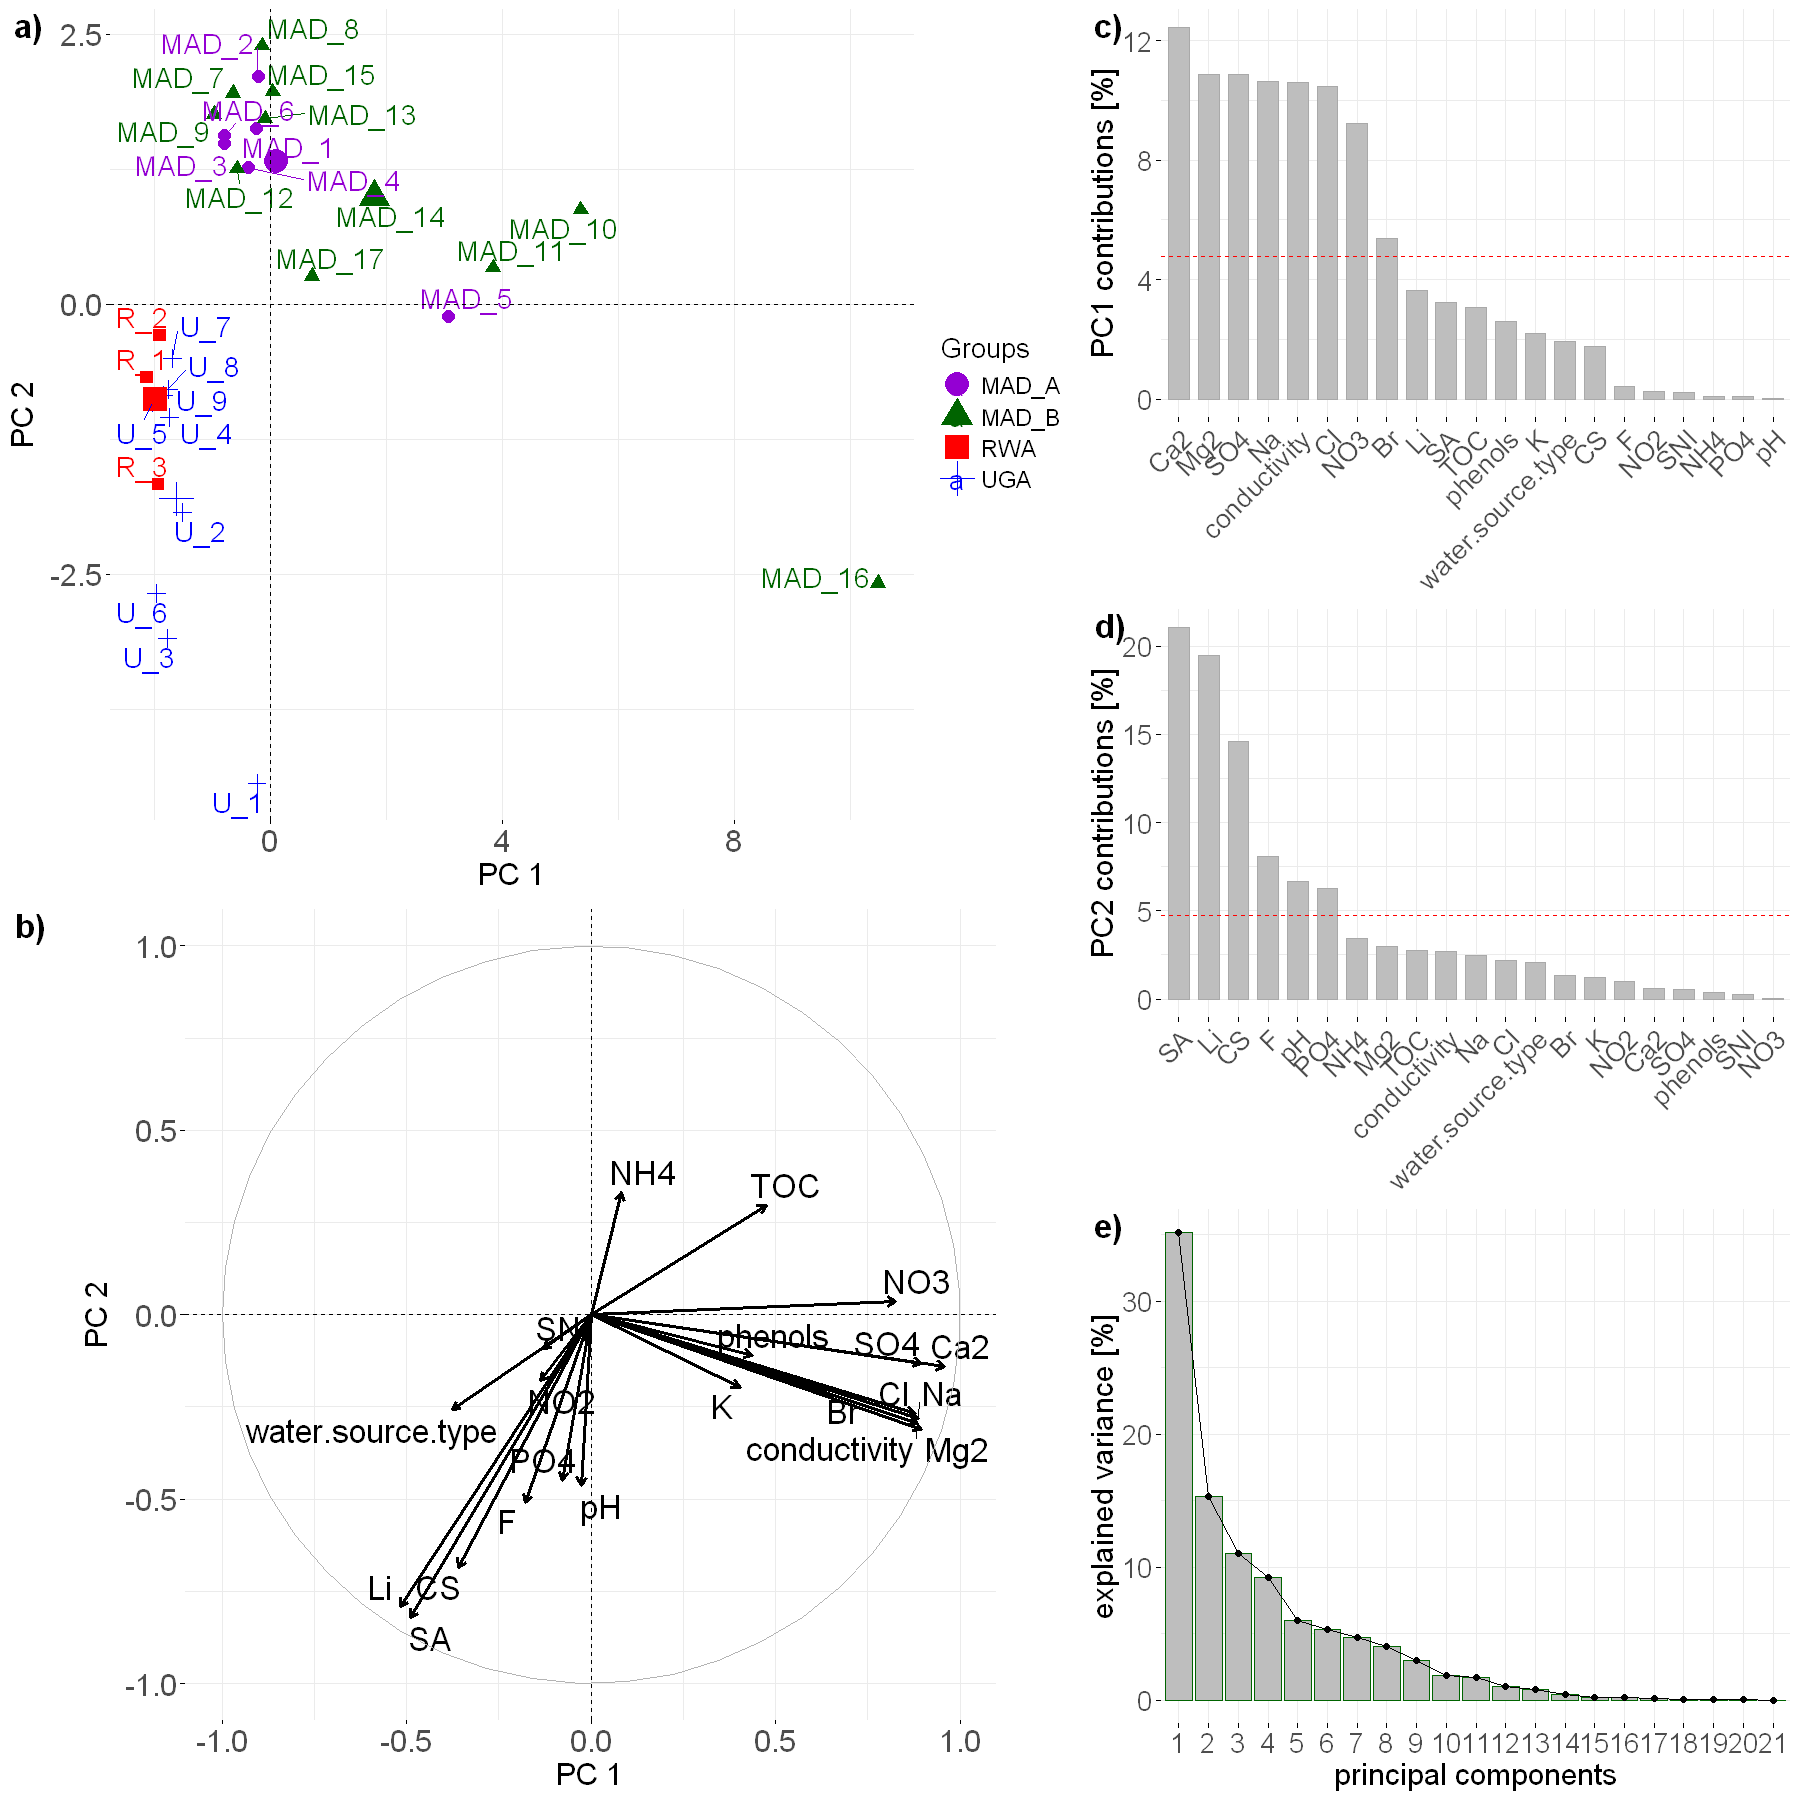

In [9]:
options(repr.plot.width=15,repr.plot.height=15)
plot.pc1 <- fviz_pca_ind(pca.res,
             habillage=factor(df$measurement.series),
             palette = c("darkviolet","darkgreen", "red", "blue"),
             repel = TRUE,     # Avoid text overlapping
             addEllipses=FALSE, 
             ellipse.level=0.95,labelsize = 6,pointsize=3.2,title=NULL ) +  
             labs(title = NULL,x = "PC 1", y = "PC 2") +
             pca.theme 


plot.pc2 <- fviz_pca_var(pca.res, col.var = "black",title=NULL,repel=TRUE,labelsize = 7,arrowsize = 1) +             
             labs(title = NULL,x = "PC 1", y = "PC 2") +
             pca.theme 

# Contributions of variables to PC1
plot.pc3 <- fviz_contrib(pca.res, choice = "var", axes = 1, top = ncol(pca.res$x),fill = "gray",color="darkgray") +
             labs(title = NULL,x = "variables", y = "PC1 contributions [%]") +
             pca.theme + theme(axis.text = element_text(size = 16))
# Contributions of variables to PC2
plot.pc4 <- fviz_contrib(pca.res, choice = "var", axes = 2, top = ncol(pca.res$x),fill = "gray",color="darkgray") +
             labs(title = NULL,x = "variables", y = "PC2 contributions [%]") +
             pca.theme + theme(axis.text = element_text(size = 16))

plot.pc5 <- fviz_eig(pca.res,ncp=ncol(pca.res$x),addlabels=FALSE,barfill = "gray",linecolor="black",barcolor = "darkgreen") + 
labs(title = NULL,x = "principal components", y = "explained variance [%]") + 
pca.theme + theme(axis.text = element_text(size = 16))

c1 <- plot_grid(plot.pc1,plot.pc2,labels = c("a)","b)"),label_size = 20,ncol=1,rel_heights=c(1,1,0.8))
c2 <- plot_grid(plot.pc3,plot.pc4,plot.pc5,labels = c("c)","d)","e)"),label_size = 20,ncol=1)
plot_grid(c1,c2,ncol=2,rel_widths=c(1.5,1))

#ggsave(paste0(img.path,"PCA_new_complete.tiff"),height=15,width=15,dpi=600,compression="lzw",bg = 'white')
#ggsave(paste0(img.path,"PCA_new_complete.PNG"),height=15,width=15,dpi=150,bg = 'white')

### 3. Samples clustering

In [10]:
feat.clust <- c('conductivity','F','Cl','Br','NO3','NO2','SO4','PO4','Li','Na','K','NH4','Ca2','Mg2','TOC','phenols','CS','SA','SNI')
df.clust <- df[feat.clust]
rownames(df.clust) <- paste(df$water.source.type.flag, df$water.source.type,sep=": ")
head(df.clust,3)

,conductivity,F,Cl,Br,NO3,NO2,SO4,PO4,Li,Na,K,NH4,Ca2,Mg2,TOC,phenols,CS,SA,SNI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAD1: lake,103.5,0.827,12.40,0.18,1.60,0.27,2.438,0.270,0.03,13.544,11.253,9.401,0.030,0.030,8.165,0.254,0.05,0.05,0.1
MAD2: lake,155.3,0.203,4.20,0.18,0.18,0.27,1.470,0.818,0.03,13.975,11.529,9.815,1.016,1.409,8.459,0.044,0.05,0.05,0.1
MAD3: lake,77.2,0.188,1.59,0.18,0.18,0.27,0.989,0.764,0.03,8.936,3.367,3.314,0.777,0.889,3.925,0.040,0.05,0.05,0.1


In [11]:
df.clust.scaled <- scale(df.clust,center = TRUE,scale = TRUE)
distance = dist(df.clust.scaled)

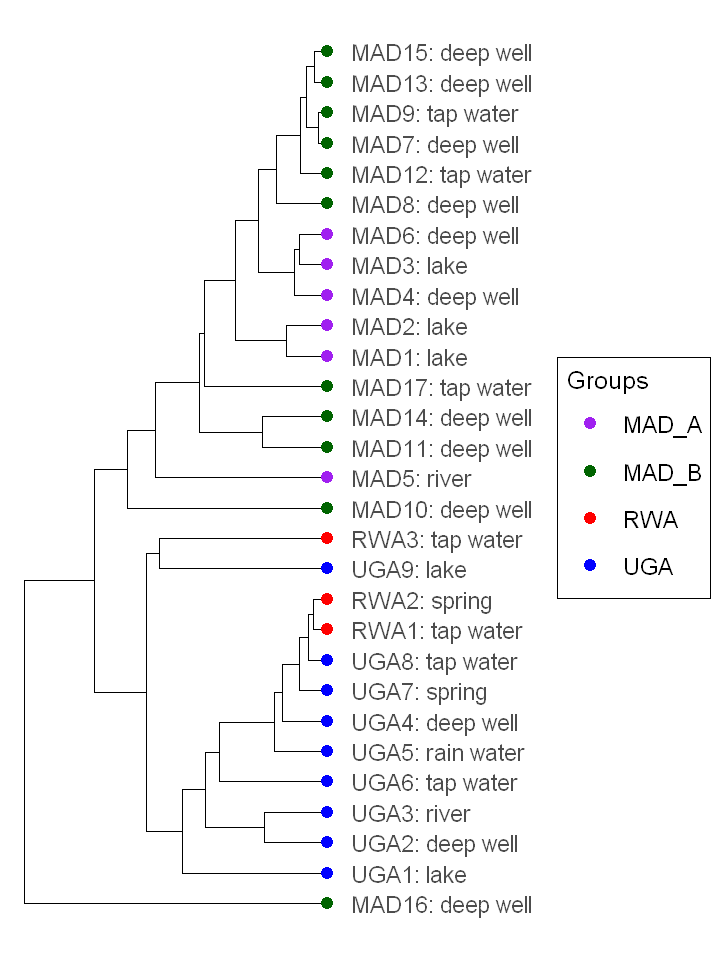

In [12]:
hc <- hclust(distance)
# plot(hc)
dhc <- as.dendrogram(hc)

ddata <- dendro_data(dhc, type = "rectangle")

# determine the label colours
m <- str_replace(str_extract(ddata$labels$label, regex("^(.*?):")),":","") # get the names of the measurement from the clust label
colours <- NULL
for (e in m){
   b <- df$water.source.type.flag == e
   ms <- df[b,"measurement.series"]
   colours <- c(colours,ms)
}
ddata$labels$colour <- colours

options(repr.plot.width=6,repr.plot.height=8)
 ggplot(ddata$segments) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend))+
  geom_point(data=ddata$labels,aes(x=x,y=y,colour=colour),size=3)+
  #geom_text(data = ddata$labels, aes(x, y, label = label),
  #          hjust = 0, angle =0, size = 6)+
   coord_flip() + scale_x_continuous(breaks=ddata$labels$x, labels = ddata$labels$label,position="top")+ scale_y_reverse()+ 

  scale_colour_manual(values=c("MAD_A"="purple", "MAD_B"="darkgreen","RWA"="red","UGA"="blue"),name="Groups") + 

theme_bw() + theme(axis.text.y = element_text(size=14),
                   axis.text.x = element_blank(),
                   axis.ticks.x = element_blank(),
                   axis.title = element_blank(),
                   
                   legend.position.inside=c(.15,.85),
                   legend.key.size = unit(2, 'cm'), 
                   legend.key.height = unit(1, 'cm'), 
                   legend.key.width = unit(1, 'cm'), 
                    legend.title = element_text(size=15), 
                   legend.text = element_text(size=14)   ,               
                   legend.background = element_blank(),
        legend.box.background = element_rect(colour = "black"),
                   
                   panel.grid.minor.y = element_blank(),
                   panel.grid.major.x = element_blank(),
                   axis.line.y.right = element_blank(),
                   axis.ticks.y.right = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank() ) 

#ggsave(paste0(img.path,"cluster.tiff"),height=8,width=6,dpi=600,compression="lzw")
#ggsave(paste0(img.path,"cluster.PNG"),height=8,width=6,dpi=150)

### 4. Additional analyses recommended by reviewers

#### 4.1. Correlation analysis of Na vs. Cl in Madagascar deep well
The concentrations of Na and Cl are strongly correlated in deep well water samples collected in Madagascar. The Pearsone correlation coefficient turned out to be significant in the case of analyzed relatioship between Na and Cl. Correlation coefficient is equal to R=0.99 (p-value = 1.354e-08). Such sitiation did not take place in case of the lake and tap water for which the determined Pearsone coefficients turned out to be statistically insignificant. The obtained R values for lake and tap water were equal 0.628 (p-value = 0.5672) and 0.189 (p-value = 0.8785) respectively.
Due to insufficient number of samples in other cases (Uganda, Rwanda, Madagascar - lake water) it was impossible to perform correlation analysis.

In [13]:
tmp.df <- df %>% 
          filter(country=='Madagascar' & water.source.type=='deep well') %>% 
          select(c("Cl","Na","water.source.type","measurement.series"))
head(tmp.df,3)

,Cl,Na,water.source.type,measurement.series
,<dbl>,<dbl>,<chr>,<chr>
1,4.686,36.5270,deep well,MAD_A
2,1.495,9.7810,deep well,MAD_A
3,5.490,2.2796,deep well,MAD_B


`geom_smooth()` using formula = 'y ~ x'


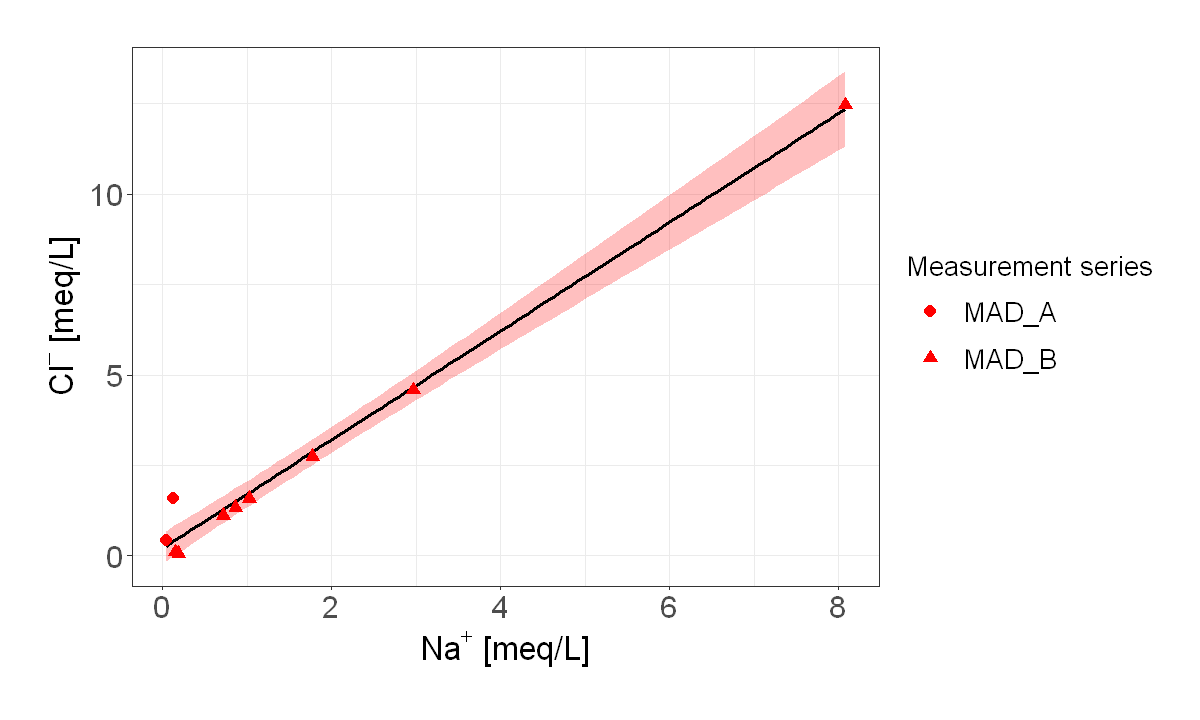

In [14]:
options(repr.plot.height=6,repr.plot.width=10)

tmp.df <- df %>% 
       filter(country=='Madagascar' & water.source.type=='deep well') %>% 
       select(c("meq.Cl","meq.Na","water.source.type","measurement.series"))

ggplot(data=tmp.df,aes(x=meq.Cl,y=meq.Na))  + geom_smooth(method = "lm",color="black",fill="red",alpha=0.25) + geom_point(size=3,color="red",aes(shape=measurement.series)) +
xlab(TeX("$Na^+$ [meq/L]")) + ylab(TeX("$Cl^-$ [meq/L]")) +
labs(shape = "Measurement series") + 
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                #   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm")) 

In [15]:
df %>% filter(country=='Madagascar' & water.source.type %in% c('deep well','lake','tap water')) %>% 
        select(c("water.source.type","Cl","Na")) %>% 
            group_by(water.source.type) %>%  
                summarise(R=cor.test(Cl,Na)$estimate,p.value=cor.test(Cl,Na)$p.value)

water.source.type,R,p.value
<chr>,<dbl>,<dbl>
deep well,0.9925246,1.353967e-08
lake,0.6286664,5.672022e-01
tap water,0.1896202,8.785487e-01


#### 4.2. Plots displaying the relationships between ions

Warning message in get_plot_component(plot, "guide-box"):
"Multiple components found; returning the first one. To return all, use `return_all = TRUE`."
Warning message in as_grob.default(plot):
"Cannot convert object of class logical into a grob."
`geom_smooth()` using formula = 'y ~ x'


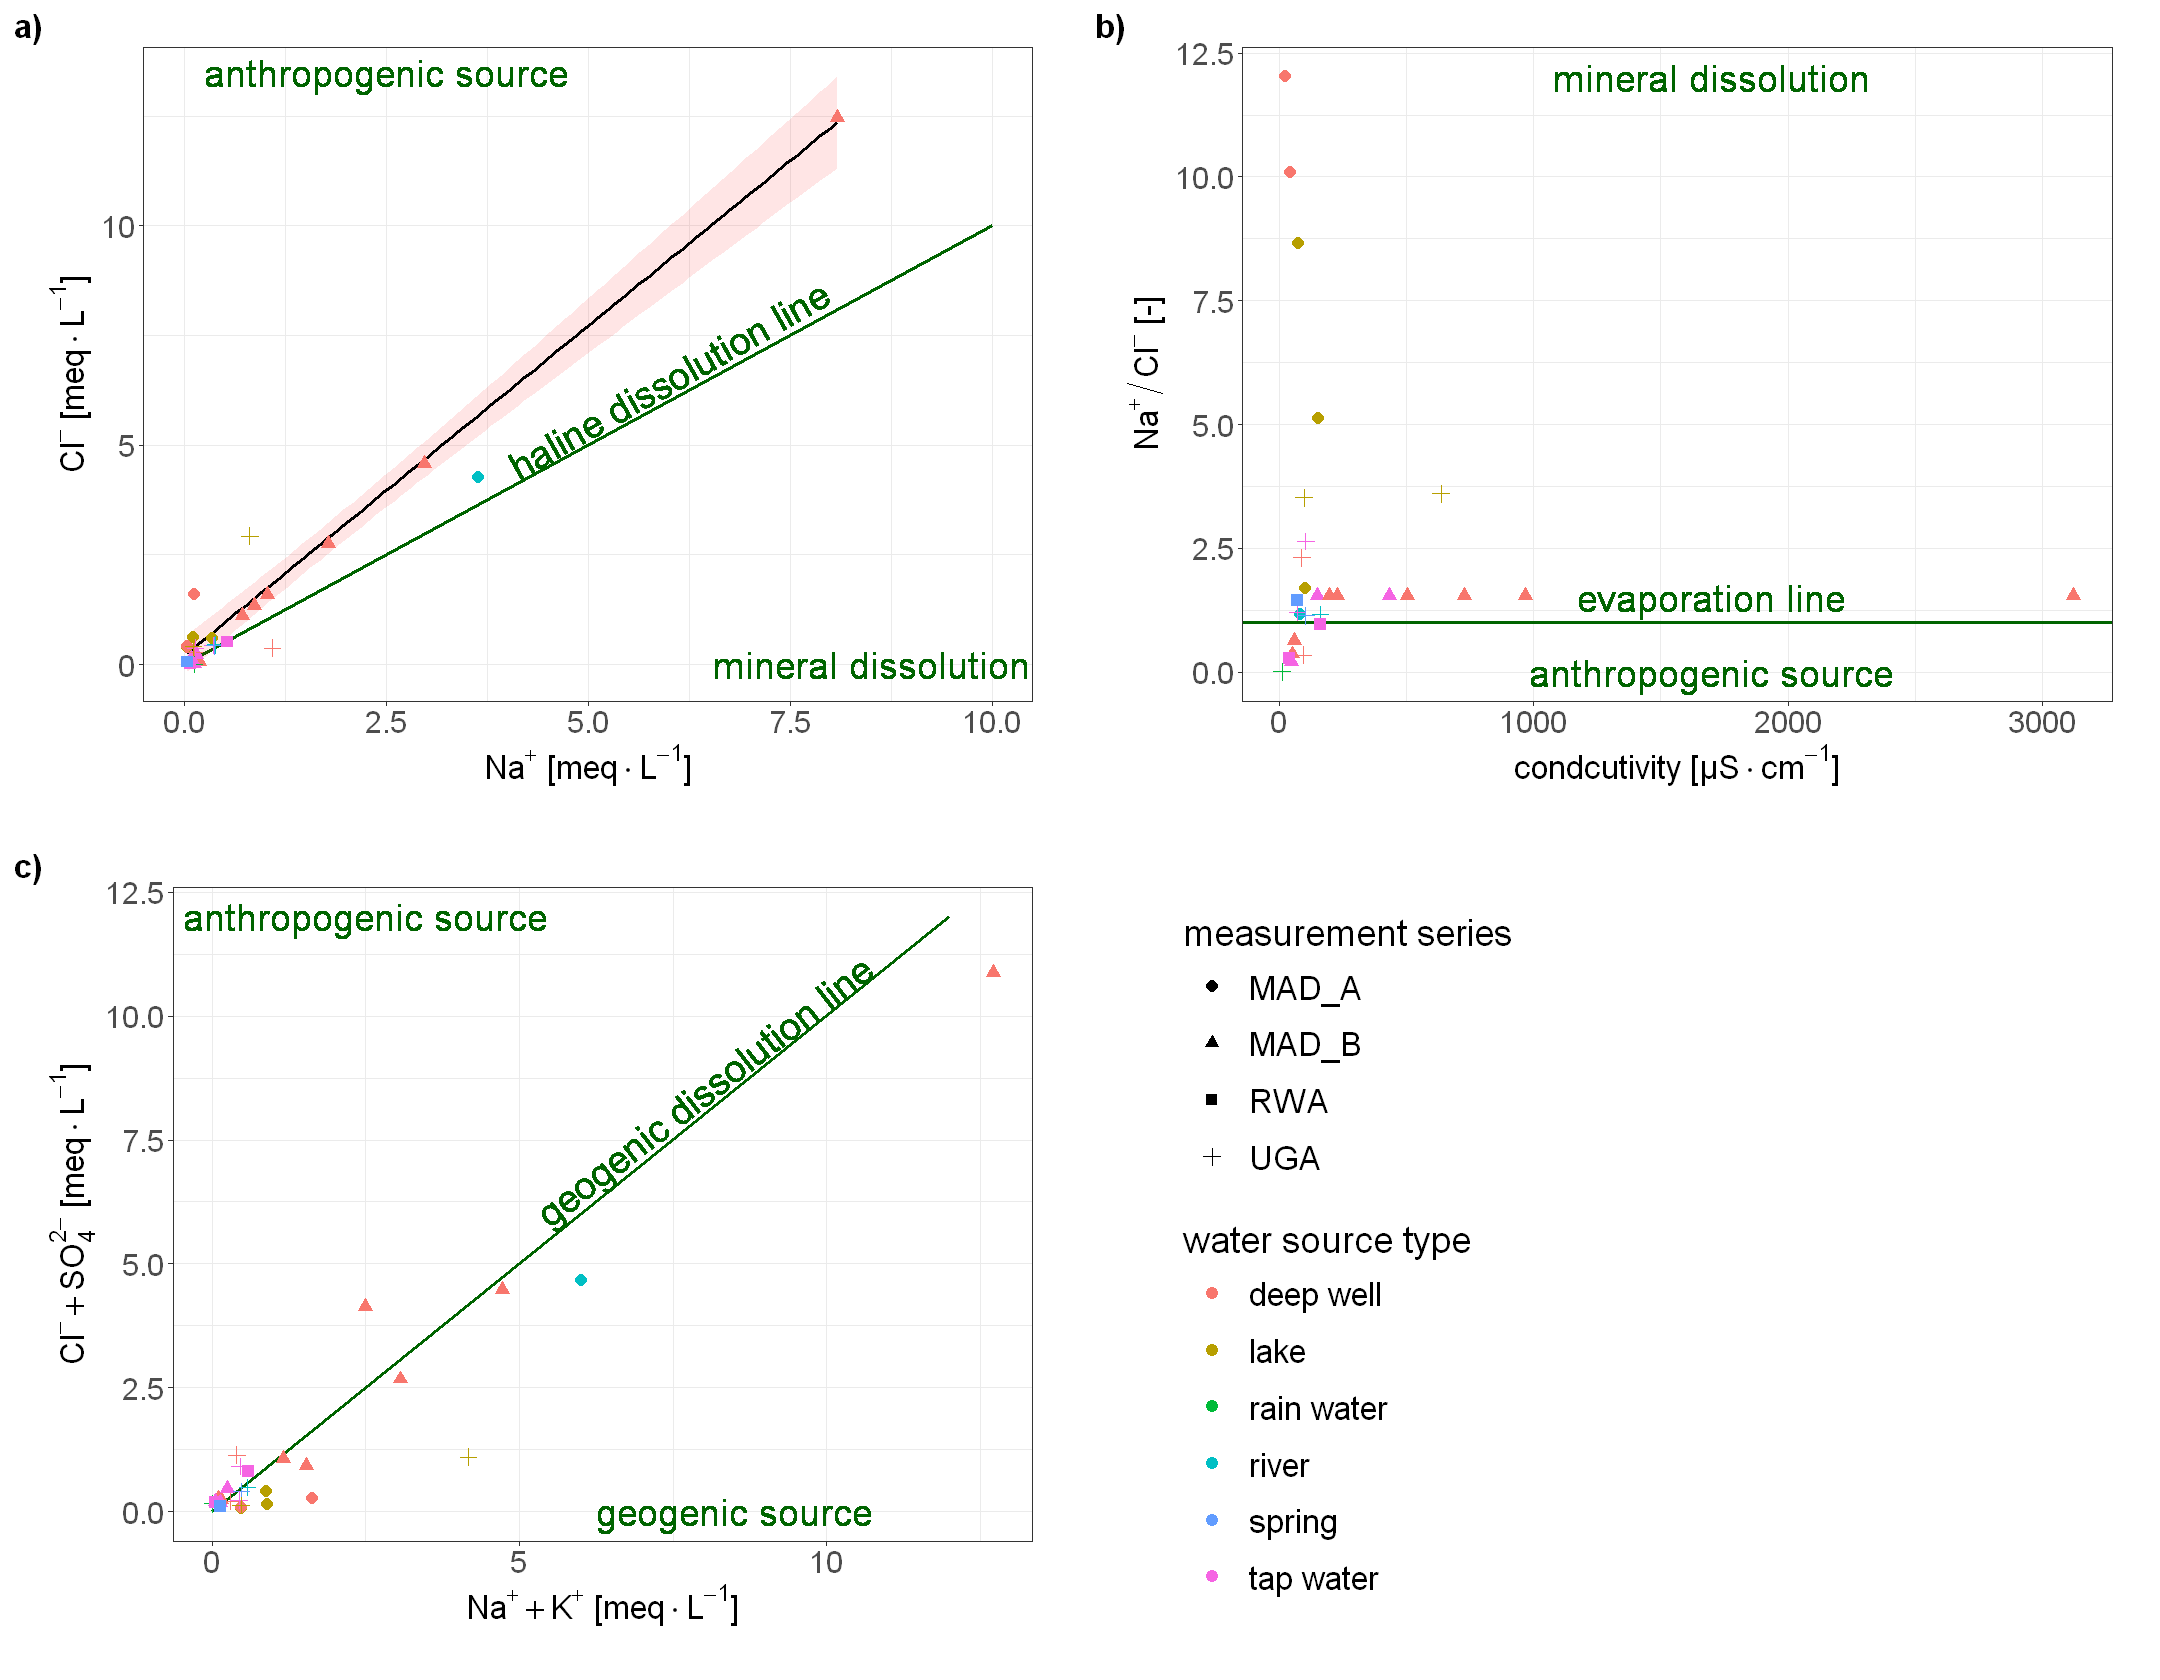

In [16]:
# plot made just for getting properly formatted legend
df.line45deg = data.frame(x=c(0,12),y=c(0,12))

p3.meq <- ggplot(data=df,aes(x=`meq.Na+K`,y=`meq.Cl+SO4`))   + 
geom_line(data=df.line45deg,aes(x=x,y=y),linewidth=1,color="darkgreen")+
geom_text(x=2.5,y=12,size=8,color="darkgreen",label="anthropogenic source") + 
geom_text(x=8.5,y=0,size=8,color="darkgreen",label="geogenic source") + 
geom_text(x=8,y=8.5,angle = 36,size=8,color="darkgreen",label="geogenic dissolution line") + 
geom_point(size=3,aes(shape=measurement.series,color=water.source.type)) +
xlab(TeX("$Na^++K^+$ [meq/L]")) + ylab(TeX("$Cl^-+SO_4^{2-}$ [meq/L]")) +
labs(shape = "measurement series",color="water source type") +
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                #   legend.position="none",
                   legend.key.size = unit(2.5, 'cm'), #change legend key size
                   legend.key.height = unit(1.2, 'cm'), #change legend key height
                   legend.key.width = unit(1.2, 'cm'), #change legend key width
                   legend.title = element_text(size=22), #change legend title font size
                   legend.text = element_text(size=20),
                  plot.margin = unit(c(1,1,1,1), "cm")) 
meq.leg <- get_legend(p3.meq)

options(repr.plot.height=14,repr.plot.width=18)

df.line45deg1 = data.frame(x=c(0,10),y=c(0,10))
p1.meq <- ggplot(data=df,aes(x=meq.Cl,y=meq.Na))   + 
geom_line(data=df.line45deg1,aes(x=x,y=y),linewidth=1,color="darkgreen")+ 

geom_smooth(data=df %>% 
            filter(country=='Madagascar' & water.source.type=='deep well') %>% 
                 select(c("meq.Cl","meq.Na","water.source.type","measurement.series")), aes(x=meq.Cl,y=meq.Na),method = "lm",color="black",fill="red",alpha=0.1) + 

geom_text(x=2.5,y=13.5,size=8,color="darkgreen",label="anthropogenic source") + 
geom_text(x=8.5,y=0,size=8,color="darkgreen",label="mineral dissolution") + 
geom_text(x=6,y=6.5,angle = 29.5,size=8,color="darkgreen",label="haline dissolution line") + 
geom_point(size=3,aes(shape=measurement.series,color=water.source.type)) +
xlab(TeX("$Na^+$ $[meq \\cdot L^{-1} ]$")) + ylab(TeX("$Cl^{-}$ $[meq \\cdot L^{-1} ]$")) +
labs(shape = "measurement\nseries",color="water\nsource type") + 
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm"))


p2.meq <- ggplot(data=df,aes(x=conductivity,y=meq.Na/meq.Cl))   + 
geom_hline(yintercept=1.0,linewidth=1,color="darkgreen") +
geom_text(x=1700,y=1.5,size=8,color="darkgreen",label="evaporation line") + 
geom_text(x=1700,y=12,size=8,color="darkgreen",label="mineral dissolution") + 
geom_text(x=1700,y=0,size=8,color="darkgreen",label="anthropogenic source") + 
geom_point(size=3,aes(shape=measurement.series,color=water.source.type)) +
xlab(TeX("condcutivity $[μS \\cdot cm^{-1}]$")) + ylab(TeX("$Na^+/Cl^-$ [-]")) +
labs(shape = "measurement\nseries",color="water\nsource type") +
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm")) 

df.line45deg3 = data.frame(x=c(0,12),y=c(0,12))
p3.meq <- ggplot(data=df,aes(x=`meq.Na+K`,y=`meq.Cl+SO4`))   + 
geom_line(data=df.line45deg3,aes(x=x,y=y),linewidth=1,color="darkgreen")+
geom_text(x=2.5,y=12,size=8,color="darkgreen",label="anthropogenic source") + 
geom_text(x=8.5,y=0,size=8,color="darkgreen",label="geogenic source") + 
geom_text(x=8,y=8.5,angle = 38,size=8,color="darkgreen",label="geogenic dissolution line") + 
geom_point(size=3,aes(shape=measurement.series,color=water.source.type)) +
xlab(TeX("$Na^++K^+$ $ [ meq \\cdot L^{-1}  ]$")) + ylab(TeX("$Cl^-+SO_4^{2-}$ $[meq \\cdot L^{-1} ]$")) +
labs(shape = "measurement\nseries",color="water\nsource type") +
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm"))

plot_grid(p1.meq,p2.meq,p3.meq,plot_grid(meq.leg,NA),labels=c("a)","b)","c)"),label_size=20,nrow=2)
#ggsave(paste0(img.path,"meq_all_v3.tiff"),height=14,width=18,dpi=600,compression="lzw",bg="white")
#ggsave(paste0(img.path,"meq_all_v3.PNG"),height=14,width=18,dpi=150,bg="white")

#### 4.2. Kendall $\tau$ correlation matrix

In [18]:
source("tau_correlation_matrix.R") # read function for determining the matrix

Warning message in get_plot_component(plot, "guide-box"):
"Multiple components found; returning the first one. To return all, use `return_all = TRUE`."


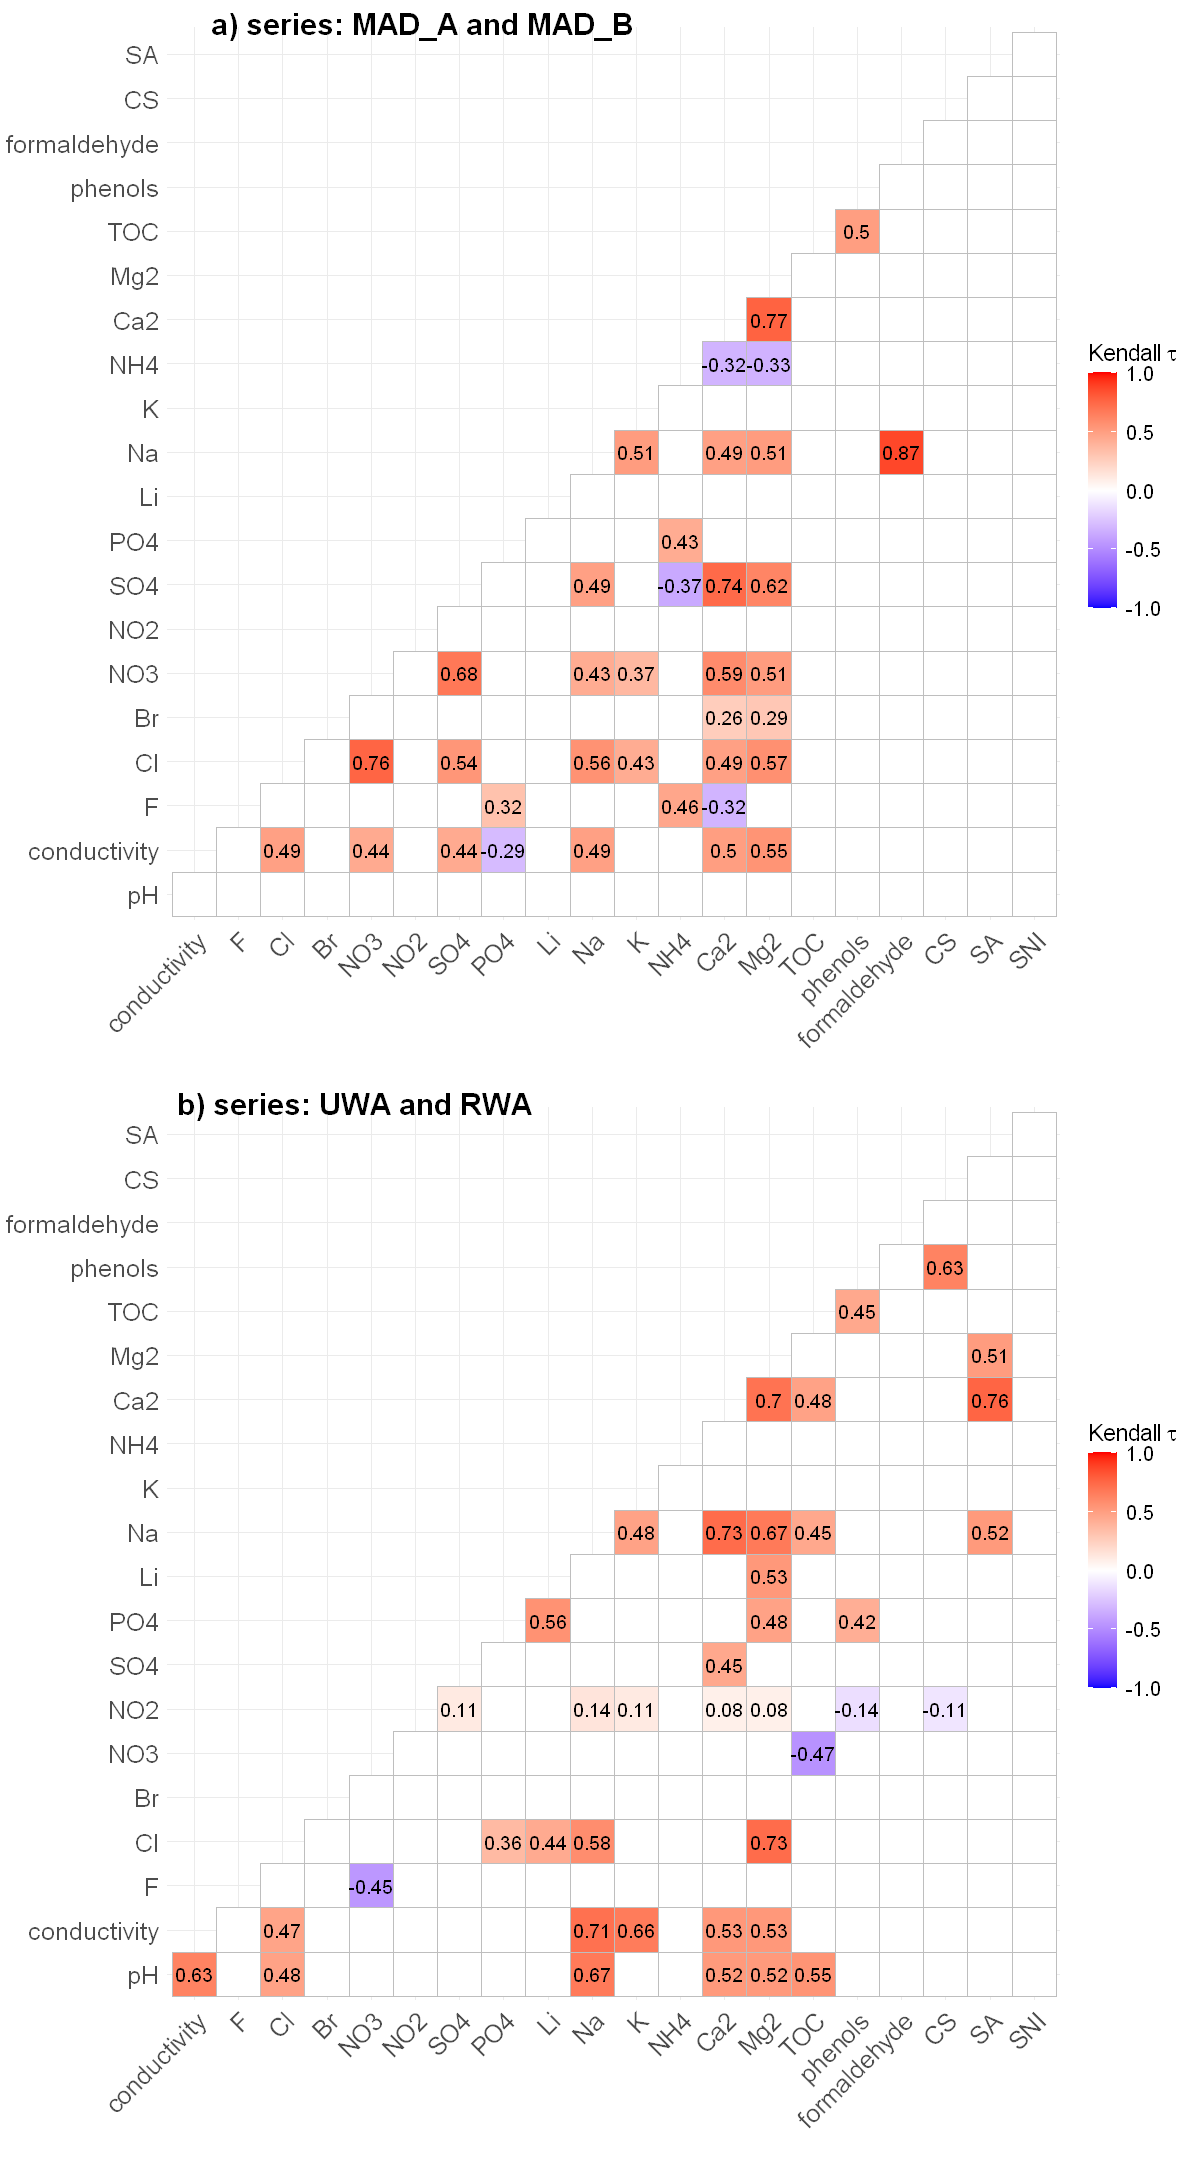

In [19]:
tmp.df <- df %>% filter(measurement.series == "MAD_A" | measurement.series == "MAD_B" )

corr.feat <- c('pH','conductivity','F','F.LOQ','Cl','Cl.LOQ','Br','Br.LOQ','NO3','NO3.LOQ','NO2','NO2.LOQ','SO4','SO4.LOQ','PO4','PO4.LOQ','Li','Li.LOQ','Na','Na.LOQ',
               'K','K.LOQ','NH4','NH4.LOQ','Ca2','Ca2.LOQ','Mg2','Mg2.LOQ','TOC','TOC.LOQ','phenols','phenols.LOQ','formaldehyde','formaldehyde.LOQ','CS','CS.LOQ','SA','SA.LOQ','SNI','SNI.LOQ')

corr.df <- tmp.df[corr.feat]
corr.df$pH.LOQ <- FALSE
corr.df$conductivity.LOQ <- FALSE
corr.feat <- c('pH','pH.LOQ','conductivity','conductivity.LOQ','F','F.LOQ','Cl','Cl.LOQ','Br','Br.LOQ','NO3','NO3.LOQ','NO2','NO2.LOQ','SO4','SO4.LOQ','PO4','PO4.LOQ','Li','Li.LOQ','Na','Na.LOQ',
               'K','K.LOQ','NH4','NH4.LOQ','Ca2','Ca2.LOQ','Mg2','Mg2.LOQ','TOC','TOC.LOQ','phenols','phenols.LOQ','formaldehyde','formaldehyde.LOQ','CS','CS.LOQ','SA','SA.LOQ','SNI','SNI.LOQ')

corr.df <- corr.df[corr.feat]
#head(corr.df)

options(warn=-1)
t.res <- tau(corr.df)
options(warn=0)


T <- round(t.res$tau,2)
P <- t.res$p

T[is.na(T)] <- 0 
P[is.na(P)] <- 1

p.tmp <- ggcorrplot(T,p.mat = P, type = "lower", outline.col = "gray",lab = TRUE,insig = "blank",tl.cex = 15, lab_size = 4, legend.title = TeX("Kendall \\tau")) +
theme(legend.key.height =  unit(1, 'cm'),
      legend.title = element_text(size=14),
       legend.text = element_text(size=12)
     )

leg <- get_legend(p.tmp)


p1 <- ggcorrplot(T,p.mat = P, type = "lower", outline.col = "gray",lab = TRUE,insig = "blank",tl.cex = 15, lab_size = 4, legend.title = TeX("Kendall \\tau")) +
theme(legend.key.height =  unit(1, 'cm'),
      legend.title = element_text(size=14),
       legend.text = element_text(size=12)
     )


## ---------------------------------------------------------------------------
tmp.df <- df %>% filter(measurement.series == "UGA" | measurement.series == "RWA" )

corr.feat <- c('pH','conductivity','F','F.LOQ','Cl','Cl.LOQ','Br','Br.LOQ','NO3','NO3.LOQ','NO2','NO2.LOQ','SO4','SO4.LOQ','PO4','PO4.LOQ','Li','Li.LOQ','Na','Na.LOQ',
               'K','K.LOQ','NH4','NH4.LOQ','Ca2','Ca2.LOQ','Mg2','Mg2.LOQ','TOC','TOC.LOQ','phenols','phenols.LOQ','formaldehyde','formaldehyde.LOQ','CS','CS.LOQ','SA','SA.LOQ','SNI','SNI.LOQ')
corr.df <- tmp.df[corr.feat]
corr.df$pH.LOQ <- FALSE
corr.df$conductivity.LOQ <- FALSE
corr.feat <- c('pH','pH.LOQ','conductivity','conductivity.LOQ','F','F.LOQ','Cl','Cl.LOQ','Br','Br.LOQ','NO3','NO3.LOQ','NO2','NO2.LOQ','SO4','SO4.LOQ','PO4','PO4.LOQ','Li','Li.LOQ','Na','Na.LOQ',
               'K','K.LOQ','NH4','NH4.LOQ','Ca2','Ca2.LOQ','Mg2','Mg2.LOQ','TOC','TOC.LOQ','phenols','phenols.LOQ','formaldehyde','formaldehyde.LOQ','CS','CS.LOQ','SA','SA.LOQ','SNI','SNI.LOQ')

corr.df <- corr.df[corr.feat]
#head(corr.df)

options(warn=-1)
t.res <- tau(corr.df)
options(warn=0)


T <- round(t.res$tau,2)
P <- t.res$p

T[is.na(T)] <- 0 
P[is.na(P)] <- 1
#ggcorrplot(T, type = "lower", outline.col = "gray",lab = TRUE,insig = "blank")
p2 <- ggcorrplot(T,p.mat = P, type = "lower", outline.col = "gray",lab = TRUE,insig = "blank",tl.cex = 15, lab_size = 4, legend.title = TeX("Kendall \\tau")) +
#theme(legend.position="none")
# theme(legend.position="none")
theme(legend.key.height =  unit(1, 'cm'),
      legend.title = element_text(size=14),
       legend.text = element_text(size=12)
     )

options(repr.plot.height=18,repr.plot.width=10)

cowplot::plot_grid(p1, p2, labels = c('a) series: MAD_A and MAD_B', 'b) series: UWA and RWA'), label_size = 18,nrow=2,rel_heights = c(1, 1))
#ggsave(paste0(img.path,"kendall-tau.tiff"),height=18,width=9,dpi=600,compression="lzw")
#ggsave(paste0(img.path,"kendall-tau.png"),height=18,width=9,dpi=150)